In [196]:
#imports
import matplotlib.pyplot as plt
import numpy as np

# Elastancia:

In [197]:
#setup
T = 1.0
dt = 0.0001
t = np.arange(0,4*T,dt)

In [198]:
#elastancia setup
Emax = 2
Emin = 0.06
HR = 60
tc = 60 / HR
Tmax = 0.2 + 0.15*tc

### Temos que:

\begin{gather*} 
E_n(t_n) = 1.55 * \left[ \frac{\left(\frac{t_n}{0.7}\right)^{1.9}}{1 + \left(\frac{t_n}{0.7}\right)^{1.9}} \right] * \left[ \frac{1}{1 + \left(\frac{t_n}{1.17}\right)^{21.9}} \right]
\end{gather*} 

In [199]:
def En(tn):
    tn = (tn % T)/Tmax
    v1 = ((tn / 0.7)**1.9)  
    v2 = ((tn / 1.17)**21.9)
    return 1.55 * (v1 / (1 + v1)) * (1 / (1 + v2))

### De forma que $E_n(t_n)$ é usada na equação descrita abaixo

\begin{gather*} 
E(t) = (E_{max} - E_{min})E_n(t_n) + E_{min}
\end{gather*} 

In [200]:
def Et(t):
    return (Emax - Emin) * En(t) + Emin

In [201]:
#resultado
E = []
for i in (t):
    E.append(Et(i))

# Modelagem:

### As seguintes equações foram utilizadas para representar o modelo:

### *Pressão no átrio esquerdo:*

\begin{gather*}
\dot{P_{ae}}\left ( t \right ) = P_{ae}\left ( t \right )\left (-\frac{1}{R_sC_r}-\frac{D_m}{R_mCr}\right) + P_{ve}\left ( t \right )\left ( \frac{D_m}{R_mC_r} \right ) + P_{as}\left ( t \right )\left ( \frac{1}{R_sCr} \right)
\end{gather*}


### *Volume no ventrículo esquerdo:*

\begin{gather*}
\dot{V_{ve}}\left ( t \right ) = \frac{D_a}{R_a}P_{ao}\left ( t \right )-\left ( \frac{D_m}{R_m}+\frac{D_a}{R_a} \right )E\left ( t \right )V_{ve}\left ( t \right )+\frac{D_m}{R_m}P_{ae}\left ( t \right ) + \left ( \frac{D_m}{R_m}+\frac{D_a}{R_a} \right )E\left ( t \right )V_{o}
\end{gather*}


### *Pressão na aorta:*

\begin{gather*}
\dot{P_{ao}}\left ( t \right ) = P_{ve}\left ( t \right )\left ( \frac{D_a}{R_aC_a} \right )+P_{ao}\left ( t \right )\left ( -\frac{D_a}{R_aC_a} \right )+Q\left ( t \right )\left ( -\frac{1}{C_a} \right )
\end{gather*}

### *Fluxo no ventriculo esquerdo:*

\begin{gather*}
\dot{Q}\left ( t \right ) = P_{ao}\left ( t \right )\left ( \frac{1}{L_s} \right) + Q\left ( t \right )\left ( -\frac{R_c}{L_s} \right )+P_{as}\left ( t \right )\left (-\frac{1}{L_s}  \right )
\end{gather*}

### *Pressão arterial sistemica:*

\begin{gather*}
\dot{P_{as}}\left ( t \right ) = Q\left ( t \right )\left ( \frac{1}{C_s} \right )+P_{ae}\left ( t \right )\left ( \frac{1}{C_sR_s} \right )+P_{as}\left ( t \right )\left ( -\frac{1}{R_sC_s} \right )
\end{gather*}


### *De forma que:*

\begin{gather*}
P_{ve} = E\left ( t \right )\left ( V_{ve} - V_o \right )
\end{gather*}


### Constantes:

In [202]:
#resistences
Rs = 1.0000
Rm = 0.0050
Ra = 0.0010
Rc = 0.0398

#compliances
#C(t) variável no tempo
Cr = 4.4000
Cs = 1.3300
Ca = 0.0800

#inertances
Ls = 0.0005

V0 = 10

### Vetores utilizados para guardar os resultados:

In [203]:
#setup
Pae = np.zeros(len(t)) 
Vve = np.zeros(len(t))
Pao = np.zeros(len(t))
Q   = np.zeros(len(t))
Pas = np.zeros(len(t))
Pve = np.zeros(len(t))

### Condições iniciais:

In [204]:
Pae[0] = 5   
Vve[0] = 140 
Pao[0] = 90
Q  [0] = 0
Pas[0] = 90
Pve[0] = (Vve[0] - V0)*E[0]

### Resolvendo as EDO's 

In [205]:
#o próximo ponto é igual ao ponto anterior somado ao passo de integração multiplicado pelo modelo da variável de estado
for i in range(len(t)-1):

    Dm = (1 if Pae[i] >= Pve[i] else 0)
    Da = (1 if Pve[i] >= Pao[i] else 0)

    Vve[i+1] = Vve[i]  +dt*( (Da/Ra)*Pao[i] - (Dm/Rm + Da/Ra)*E[i]*Vve[i] + (Dm/Rm)*Pae[i] + (Dm/Rm + Da/Ra)*E[i]* V0)
    Pve[i+1] = E[i+1]*(Vve[i+1] - V0)

    Pae[i+1] = Pae[i]  +dt*(-(Dm/(Cr*Rm))*(Pae[i] - Pve[i]) + (Pas[i]-Pae[i])/(Cr*Rs))
    Pao[i+1] = Pao[i]  +dt*((Da/(Ca*Ra))*(Pve[i] - Pao[i]) - Q[i]/Ca)
    Q  [i+1] =   Q[i]  +dt*((-(Rc*Q[i])/Ls) - (Pas[i]/Ls) + (Pao[i]/Ls))
    Pas[i+1] = Pas[i]  +dt*((Q[i]/Cs) - (Pas[i]-Pae[i])/(Cs*Rs))

### Resultados:

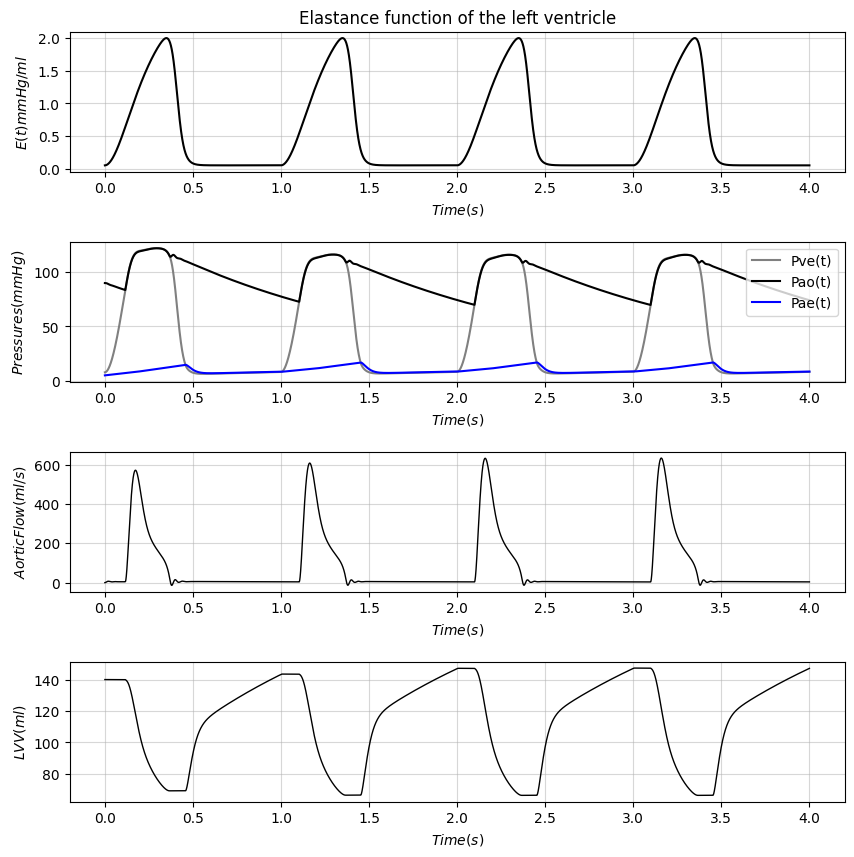

In [206]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(4, 1, 1)
plt.plot(t, E, c = 'k', lw = 1.5)
plt.grid(alpha = 0.5)
plt.title('Elastance function of the left ventricle')
plt.ylabel('$E(t) mmHg/ml$')
plt.xlabel('$Time(s)$')

plt.subplot(4, 1, 2)
plt.plot(t, Pve, c = 'gray', lw = 1.5, label = 'Pve(t)')
plt.plot(t, Pao, c = 'k', lw = 1.5, label = 'Pao(t)')
plt.plot(t, Pae, c = 'b', lw = 1.5, label = 'Pae(t)')
plt.legend(loc="upper right")
plt.grid(alpha = 0.5)
plt.ylabel('$Pressures (mmHg)$')
plt.xlabel('$Time(s)$')

plt.subplot(4, 1, 3)
plt.plot(t, Q, c = 'k', lw = 1)
plt.grid(alpha = 0.5)
plt.ylabel('$Aortic Flow (ml/s)$')
plt.xlabel('$Time(s)$')

plt.subplot(4, 1, 4)
plt.plot(t, Vve, c = 'k', lw = 1)
plt.grid(alpha = 0.5)
plt.ylabel('$LVV (ml)$')
plt.xlabel('$Time(s)$')

plt.show()